In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy.stats import boxcox, jarque_bera, normaltest
from scipy.stats.mstats import winsorize
import warnings

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

performance = pd.read_sql_query('SELECT * FROM studentsperformance', con=engine)

engine.dispose()

In [3]:
performance.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### 1) Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?

Text(0.5, 1.0, 'Writing')

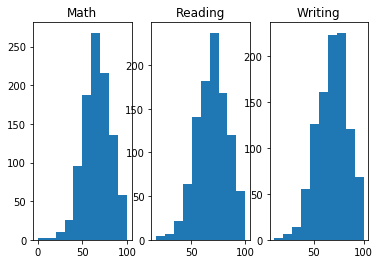

In [4]:
plt.subplot(1,3,1)
plt.hist(performance['math score'])
plt.title('Math')
plt.subplot(1,3,2)
plt.hist(performance['reading score'])
plt.title('Reading')
plt.subplot(1,3,3)
plt.hist(performance['writing score'])
plt.title('Writing')

In [5]:
box_list = ['math score', 'reading score', 'writing score']
for cox in box_list:
    winz = winsorize(performance[cox], (0.1, 0.1))
    box,_ = boxcox(winz)
    norm_jb = jarque_bera(performance[cox])
    norm_norm = normaltest(performance[cox])
    jb_stats = jarque_bera(box)
    norm_stats = normaltest(box)
    print('------{}-----'.format(cox))
    print('Before boxcox jarque_bera: {} with a p-value of: {}'.format(norm_jb[0], norm_jb[1]))
    print('Before boxcox normality test: {} with a p-value of: {}'.format(norm_norm[0], norm_norm[1]))
    print('\n')
    print('the jarque_bera score is: {} with a p-value of: {}'.format(jb_stats[0], jb_stats[1]))
    print('the normality test score is: {} with a p-value of: {}'.format(norm_stats[0], norm_stats[1]))
    print('\n')

------math score-----
Before boxcox jarque_bera: 15.912256686712709 with a p-value of: 0.0003505075386818213
Before boxcox normality test: 15.408960513931822 with a p-value of: 0.00045080293869937836


the jarque_bera score is: 53.49581629851664 with a p-value of: 2.4183988145409785e-12
the normality test score is: 440.7515777509969 with a p-value of: 1.9588940463687884e-96


------reading score-----
Before boxcox jarque_bera: 11.383300575987892 with a p-value of: 0.0033740202672214448
Before boxcox normality test: 11.11741279628622 with a p-value of: 0.003853758403576582


the jarque_bera score is: 63.19370180337561 with a p-value of: 1.8984813721090177e-14
the normality test score is: 898.1089165305441 with a p-value of: 9.508821641394081e-196


------writing score-----
Before boxcox jarque_bera: 13.98509448257235 with a p-value of: 0.0009187033894586527
Before boxcox normality test: 13.606450837263859 with a p-value of: 0.0011101885439899974


the jarque_bera score is: 59.1111087395

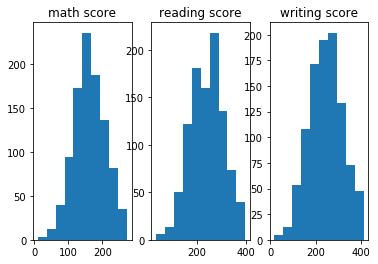

In [6]:
count = 1
for cox in box_list:
    perf = performance[performance[cox] > 0][cox] 
    box,_ = boxcox(perf)
    plt.subplot(1, 3, count)
    plt.hist(box)
    plt.title(cox)
    count += 1

The application of the boxcox transformations decreases the p-value by a lot, thus increasing the statistical significance that the histograms would be normally distributed

### 2) Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.

In [7]:
performance['exam'] = (performance['math score'] + performance['reading score'] + performance['writing score'])/3


jb_stats = jarque_bera(performance['exam'])
norm_stats = normaltest(performance['exam'])
print('------Exam-----')
print('Before boxcox jarque_bera: {} with a p-value of: {}'.format(jb_stats[0], jb_stats[1]))
print('Before boxcox normality test: {} with a p-value of: {}'.format(norm_stats[0], norm_stats[1]))

------Exam-----
Before boxcox jarque_bera: 15.453387913085168 with a p-value of: 0.00044089934264401887
Before boxcox normality test: 15.186721327231322 with a p-value of: 0.0005037851534494478


In [8]:
winz = winsorize(performance['exam'], (0.1, 0.1))
box,_ = boxcox(winz)
jb_stats = jarque_bera(box)
norm_stats = normaltest(box)
print('------Exam-----')
print('jarque_bera: {} with a p-value of: {}'.format(jb_stats[0], jb_stats[1]))
print('normality test: {} with a p-value of: {}'.format(norm_stats[0], norm_stats[1]))

------Exam-----
jarque_bera: 57.909199162350234 with a p-value of: 2.6623148130511254e-13
normality test: 591.3538989265419 with a p-value of: 3.882687362013641e-129


### 3) Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

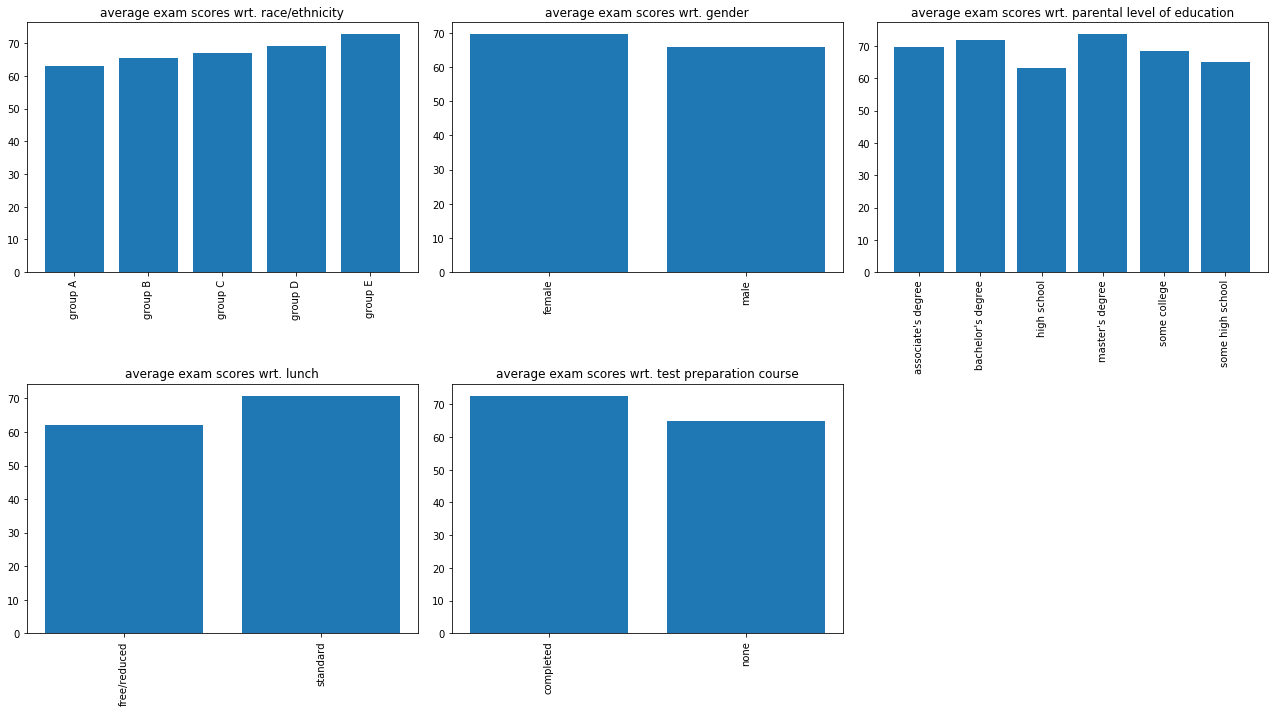

In [9]:

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.bar(performance.groupby("race/ethnicity")
        ["exam"].mean().index, performance.groupby("race/ethnicity")["exam"].mean())

plt.title("average exam scores wrt. race/ethnicity")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 2)
plt.bar(performance.groupby("gender")
        ["exam"].mean().index, performance.groupby("gender")["exam"].mean())

plt.title("average exam scores wrt. gender")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 3)
plt.bar(performance.groupby("parental level of education")
        ["exam"].mean().index, performance.groupby("parental level of education")["exam"].mean())

plt.title("average exam scores wrt. parental level of education")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 4)
plt.bar(performance.groupby("lunch")
        ["exam"].mean().index, performance.groupby("lunch")["exam"].mean())

plt.title("average exam scores wrt. lunch")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 5)
plt.bar(performance.groupby("test preparation course")
        ["exam"].mean().index, performance.groupby("test preparation course")["exam"].mean())

plt.title("average exam scores wrt. test preparation course")
plt.xticks(rotation="vertical")

plt.tight_layout()
plt.show()

There are noticeable differences between each of the categories of each histogram. This means any particular feature may be important when trying to determine how to get the highest test score.